In [1]:
import torch.nn as nn
import torch
import numpy as np
import torchvision
from torchvision import transforms
import dcgan
import matplotlib.pyplot as plt
import scipy.spatial.distance as dist
import image_utils
import csgm
import importlib
from joblib import Parallel, delayed
import os

## Setup Segmentations Beforehand

In [7]:
training = torch.load('MNIST/processed/training.pt')

In [91]:
def task(x):
    return image_utils.create_segments(x.data.numpy(),kernel_size=2,
                                 max_dist=10,
                                 ratio=0.2,
                                 target_num=8)

In [ ]:
collect = Parallel(n_jobs=1)(delayed(task)(x) for x in training[0])
np.save('./MNIST/processed/train_segmentations',collect)

In [2]:
class MNIST_Seg(torchvision.datasets.MNIST):
    
    def __init__(self, root, seg_file = None, **kwargs):
        super(MNIST_Seg, self).__init__(root, **kwargs)
        self.segments = torch.load(os.path.join(self.processed_folder, seg_file))
    
    def __getitem__(self, index):
        img, target = super(MNIST_Seg, self).__getitem__(index)
        segments = self.segments[index]
        n = torch.max(segments).item()
        r = np.random.rand(n)
        labels = np.array(range(n))[r > 0.5]
        tmp = torch.zeros_like(segments)
        for l in labels:
            tmp[segments == l] = 1
        return img, target, tmp

In [69]:
training[0].shape

torch.Size([60000, 28, 28])

In [118]:
c = np.array(collect)

In [122]:
new_training = (training[0],training[1], torch.from_numpy(c))

In [9]:
with open('MNIST/processed/training_segments.pt', 'wb') as f:
    torch.save(torch.from_numpy(collect), f)

In [7]:
collect = np.load('./MNIST/processed/train_segmentations.npy')

In [8]:
collect

array([[[0, 0, 0, ..., 2, 2, 2],
        [0, 0, 0, ..., 2, 2, 2],
        [0, 0, 0, ..., 2, 2, 2],
        ...,
        [4, 4, 4, ..., 6, 6, 6],
        [4, 4, 4, ..., 6, 6, 6],
        [4, 4, 4, ..., 6, 6, 6]],

       [[1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        ...,
        [6, 6, 6, ..., 7, 7, 7],
        [6, 6, 6, ..., 7, 7, 7],
        [6, 6, 6, ..., 7, 7, 7]],

       [[1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        ...,
        [6, 6, 6, ..., 7, 7, 7],
        [6, 6, 6, ..., 7, 7, 7],
        [6, 6, 6, ..., 7, 7, 7]],

       ...,

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 4, 4, ..., 3, 3, 3],
        [0, 4, 4, ..., 3, 3, 3],
        [0, 4, 4, ..., 3, 3, 3]],

       [[0, 0, 0, ..., 1, 1, 1],
        [0, 0, 0, ..., 1, 1, 1],
        [0, 0, 0, ..., 1, 1, 1],
        ...,
        [6, 6, 6, ..., 

In [15]:
new = torch.cat([training[0].view(-1,1,28,28),torch.from_numpy(collect).type(torch.uint8).view(-1,1,28,28)], 1)

In [17]:
t = (new, training[1])

In [3]:
transform = transforms.Compose([
                transforms.ToTensor()])
# mnist = torchvision.datasets.MNIST('./', train=True, 
#                                    transform=lambda x: transform(np.array(x)/255.).type(torch.FloatTensor)
#                                    , download=True)
mnist = MNIST_Seg('./', seg_file = 'training_segments.pt', train=True, 
                                   transform=lambda x: transform(np.array(x)/255.).type(torch.FloatTensor)
                                   , download=True)
data_loader = torch.utils.data.DataLoader(mnist,
                                          batch_size=32,
                                          shuffle=True)

In [10]:
importlib.reload(image_utils)

<module 'image_utils' from '/home/kurtis/Desktop/anchor/ImageAnchors/image_utils.py'>

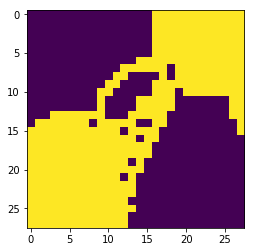

In [4]:
for X, label,seg  in data_loader:
    plt.imshow(seg.data.cpu().numpy()[0])
    break

## Probabilistic Encoder Implementation

In [346]:
class P_MNIST(nn.Module):
    
    def __init__(self, z_dim = 100, nc = 1, ndf=16, ndir = 4, device = 'cpu'):
        super(P_MNIST,self).__init__()
        self.nc = nc
        self.ndf = ndf
        self.z_dim = z_dim
        self.device = device
        self.ndir = ndir
        self.layers = nn.Sequential(
            # (nc+1) x 28 x 28
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # (ndf) x 14 x 14
            nn.Conv2d(ndf, ndf*2, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # (ndf*2) x 7 x 7
            nn.Conv2d(ndf*2, ndf*4, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # (ndf*4) x 3 x 3
        )
        self.mu = nn.Sequential(
#             nn.Linear(ndf*4*(3*3), ndf*4),
#             nn.ReLU(inplace=True),
#             nn.Dropout(0.5),
            nn.Linear(ndf*4*3*3, self.z_dim*self.ndir)
        )
        
    def forward(self, X):
        X = self.layers(X).view(-1, self.ndf * 4 * 3 * 3)
        
        return self.mu(X).chunk(self.ndir, dim=1)

## Defining Loss

$$\mathcal{L}(X) = \mathbb{E}_Z [ ||AG(Z) - AX|| ]$$

In [198]:
importlib.reload(dcgan)

<module 'dcgan' from '/home/kurtis/Desktop/anchor/ImageAnchors/dcgan.py'>

In [5]:
device = 'cuda'

In [6]:
i_se = lambda x,y: torch.sum(torch.sum(torch.nn.MSELoss(reduction='none')(x,y),dim=2),dim=2)

In [340]:
G = dcgan.load_generator().to(device).train()

In [199]:
G.main[1].parameters()

<generator object Module.parameters at 0x7f45ec300d58>

In [200]:
list(G.main[1].parameters())

[Parameter containing:
 tensor([0.7063, 0.7922, 0.7647, 1.0210, 0.6916, 0.8459, 0.8212, 0.6996, 0.8354,
         0.8023, 0.8235, 0.8511, 0.7354, 0.8422, 0.6624, 0.6313, 1.0350, 0.8896,
         0.8250, 0.8182, 0.6673, 0.7310, 1.1883, 0.7997, 0.7894, 0.7193, 0.9448,
         0.9265, 0.7720, 0.8667, 0.7584, 0.7294, 0.8362, 0.9791, 0.9081, 0.7017,
         0.8326, 0.6378, 0.8698, 0.9315, 1.0109, 0.7734, 0.7207, 1.0786, 0.7125,
         0.7547, 1.0771, 0.9359, 0.7916, 0.7768, 0.8590, 0.6200, 0.9812, 0.7669,
         0.6936, 0.7771, 0.8893, 0.7567, 0.8644, 1.0859, 0.8078, 1.0437, 1.2545,
         0.7975, 0.7265, 0.8503, 0.7299, 0.9745, 0.9981, 0.7255, 0.9450, 0.7005,
         0.6965, 0.7525, 0.8686, 0.6866, 1.2400, 0.8347, 0.8381, 0.7584, 0.6601,
         0.8105, 0.8074, 0.8046, 0.9588, 0.6806, 0.7936, 0.9592, 0.8320, 1.2267,
         0.8399, 1.0249, 0.6629, 0.8022, 0.9227, 0.7078, 0.9237, 0.8595, 0.9225,
         0.9696, 0.8119, 0.7935, 0.6335, 0.8890, 0.8633, 0.9067, 0.7028, 0.6851,
     

In [207]:
list(G.main[1].parameters())

[Parameter containing:
 tensor([0.7063, 0.7922, 0.7647, 1.0210, 0.6916, 0.8459, 0.8212, 0.6996, 0.8354,
         0.8023, 0.8235, 0.8511, 0.7354, 0.8422, 0.6624, 0.6313, 1.0350, 0.8896,
         0.8250, 0.8182, 0.6673, 0.7310, 1.1883, 0.7997, 0.7894, 0.7193, 0.9448,
         0.9265, 0.7720, 0.8667, 0.7584, 0.7294, 0.8362, 0.9791, 0.9081, 0.7017,
         0.8326, 0.6378, 0.8698, 0.9315, 1.0109, 0.7734, 0.7207, 1.0786, 0.7125,
         0.7547, 1.0771, 0.9359, 0.7916, 0.7768, 0.8590, 0.6200, 0.9812, 0.7669,
         0.6936, 0.7771, 0.8893, 0.7567, 0.8644, 1.0859, 0.8078, 1.0437, 1.2545,
         0.7975, 0.7265, 0.8503, 0.7299, 0.9745, 0.9981, 0.7255, 0.9450, 0.7005,
         0.6965, 0.7525, 0.8686, 0.6866, 1.2400, 0.8347, 0.8381, 0.7584, 0.6601,
         0.8105, 0.8074, 0.8046, 0.9588, 0.6806, 0.7936, 0.9592, 0.8320, 1.2267,
         0.8399, 1.0249, 0.6629, 0.8022, 0.9227, 0.7078, 0.9237, 0.8595, 0.9225,
         0.9696, 0.8119, 0.7935, 0.6335, 0.8890, 0.8633, 0.9067, 0.7028, 0.6851,
     

In [17]:
r_loss = lambda z,x,seg: torch.mean(i_se(G(z),((x*2)-1)) / (28*28))

## Training

In [205]:
G.train()
# G.eval()

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace)
    (12): ConvTranspose2d(64, 1, kernel_size=(1, 1), stride=(1, 1), padding=(2, 2), bias=False)
    (13): Tanh()
  )
)

In [371]:
model = P_MNIST(device=device,ndir=8).to(device)
optim = torch.optim.Adam(lr=1e-3, params = model.parameters())

In [392]:
it = 0
for e in range(n_epochs):
    for X, labels,seg in data_loader:
        optim.zero_grad()
        seg = seg.view(-1,1,28,28).type(torch.FloatTensor).to(device)
#         break
        X = X.to(device)
        target = X * seg
        n_pixels = torch.sum(torch.sum(seg,dim=2),dim=2)
        Z_list = model(target)
        diff_loss = 0
        c = 0
        for j in range(len(Z_list)):
            for k in range(j+1,len(Z_list)):
                c += 1
                distances = ( (Z_list[j] - Z_list[k])**2 - 2 ) ** 2
                diff_loss += distances.mean()
        diff_loss /= c
        Z = torch.cat(Z_list,dim=0)
#         loss = r_loss(Z,X,seg)
        Xhat = G(Z.view(-1,100,1,1))
        X = X.repeat(len(Z_list), 1, 1, 1)
        seg = seg.repeat(len(Z_list), 1, 1, 1)
        n_pixels = n_pixels.repeat(len(Z_list),1)
        errors = i_se(Xhat*seg, ((X*2)-1 ) * seg) / (n_pixels+1e-9)
#         print(errors[n_pixels>0])
        loss_r = torch.mean( errors[n_pixels > 0] )
        loss = loss_r + diff_loss
        loss.backward()
#         break
        optim.step()
#         break
        if it % 1000 == 0:
            print(loss_r.item(), diff_loss.item())
            
#         break

0.18294483423233032 3.9718658924102783
0.18624582886695862 3.9732611179351807
0.1638333648443222 3.9690871238708496
0.19566670060157776 3.9715850353240967
0.18192553520202637 3.965111017227173
0.18708425760269165 3.9705512523651123
0.1459336131811142 3.962287425994873
0.15002667903900146 3.9618310928344727
0.1527242362499237 3.9677507877349854
0.17808669805526733 3.9560959339141846
0.16413511335849762 3.959949493408203
0.2131500393152237 3.9675133228302
0.14498989284038544 3.953458070755005
0.18066594004631042 3.9330949783325195
0.23031122982501984 3.9402554035186768
0.17413407564163208 3.9528677463531494
0.19220253825187683 3.9279017448425293
0.13995280861854553 3.9233920574188232
0.11036638915538788 3.9221351146698
0.19654789566993713 3.871547222137451
0.1687193214893341 3.8516476154327393
0.21136444807052612 3.822096824645996
0.2025669366121292 3.7873270511627197
0.18477760255336761 3.8008368015289307
0.19404566287994385 3.6446449756622314
0.17347106337547302 3.6494600772857666
0.17

0.17649298906326294 2.1852898597717285
0.14879022538661957 2.076902151107788
0.14426276087760925 2.187878370285034
0.17377322912216187 2.009876251220703
0.24185101687908173 2.030092477798462
0.21877694129943848 2.297675132751465
0.17274005711078644 2.0800037384033203
0.1946127712726593 2.2828447818756104
0.15137995779514313 1.9545385837554932
0.18787574768066406 2.1492066383361816
0.2004448026418686 1.9797241687774658
0.21855276823043823 1.9879610538482666
0.2369735985994339 2.1043012142181396
0.1649674028158188 2.1579384803771973
0.15239833295345306 2.2241907119750977
0.22922490537166595 2.1643595695495605
0.16063976287841797 2.091392993927002
0.1780395209789276 2.1856839656829834
0.14842325448989868 2.104264736175537
0.18702232837677002 2.0996060371398926
0.23760299384593964 2.0332632064819336
0.22385352849960327 1.9953876733779907
0.2197248786687851 2.1527907848358154
0.17208272218704224 2.1323916912078857
0.18892231583595276 2.1992745399475098
0.2102757692337036 1.9460169076919556


0.16639384627342224 2.099130868911743
0.1733851432800293 2.059511184692383
0.17232118546962738 2.2684497833251953
0.16925562918186188 1.9448769092559814
0.17828303575515747 2.0565309524536133
0.19558754563331604 2.1159751415252686
0.1646319180727005 2.18332839012146
0.175187349319458 2.124882459640503
0.1626233458518982 2.1152992248535156
0.19307944178581238 2.048253059387207
0.14962904155254364 2.300030469894409
0.1374955177307129 2.2198853492736816
0.1923321783542633 2.031306266784668
0.16117393970489502 2.1844844818115234
0.17072097957134247 2.015613317489624
0.1725655049085617 1.9026881456375122
0.16490893065929413 2.2151551246643066
0.2029193639755249 1.998824119567871
0.17153868079185486 1.8527028560638428
0.15595346689224243 1.9281573295593262
0.16161517798900604 2.2055766582489014
0.15543654561042786 2.19281268119812
0.20332004129886627 1.9345526695251465
0.14563384652137756 2.039184093475342
0.1754220724105835 1.9819833040237427
0.14995411038398743 2.0393545627593994
0.1695504

KeyboardInterrupt: 

In [178]:
model.mu.weight.grad

tensor([[ 4.6267e-04, -1.6119e-03,  5.7192e-04,  ...,  1.1353e-04,
         -1.0572e-03,  1.6522e-04],
        [-1.1384e-03, -5.0197e-04,  2.8477e-04,  ..., -2.4366e-03,
         -1.7080e-03,  1.1323e-04],
        [ 5.6710e-04, -6.0666e-04, -2.3249e-05,  ...,  1.5123e-03,
         -2.2101e-04, -8.6559e-04],
        ...,
        [-5.4708e-04, -1.6983e-04, -1.6441e-04,  ..., -4.3036e-05,
         -6.9958e-04, -1.0161e-03],
        [ 9.1448e-04, -3.5740e-04, -3.7980e-05,  ...,  2.6141e-03,
          8.6556e-05, -1.0135e-03],
        [ 1.1288e-04, -1.5179e-05, -1.5004e-04,  ...,  9.5902e-05,
          1.2292e-04, -1.6315e-03]], device='cuda:0')

In [179]:
G.main[1].weight.grad

tensor([ 2.8933e-04, -1.5831e-04,  1.6569e-04, -2.8821e-04, -3.4527e-04,
        -5.0940e-04,  3.5267e-04, -2.8854e-04, -3.3572e-04,  2.4637e-04,
        -6.1557e-04,  1.3656e-04, -1.9343e-04,  7.2296e-07,  5.9026e-05,
         5.8239e-05, -6.6800e-04, -9.4426e-05,  1.6393e-04,  2.8974e-05,
         3.9866e-04,  1.5048e-04, -5.7512e-04, -2.8761e-04, -2.5688e-04,
         3.4845e-05, -4.7421e-06, -3.5978e-04,  7.5063e-05,  4.9673e-04,
        -3.9432e-04, -1.4319e-04, -2.0823e-04,  9.7623e-05, -1.8471e-04,
        -1.9838e-04, -5.0169e-05, -1.5589e-04,  9.7680e-06, -1.6240e-05,
         7.5993e-04, -7.9778e-06, -1.1570e-04,  6.6558e-05,  4.2391e-04,
        -2.2014e-04, -1.6826e-03,  9.0038e-04,  4.3899e-04,  6.9848e-04,
        -9.8001e-05,  3.3198e-04,  8.4682e-04,  5.9945e-05, -3.5436e-04,
         1.2866e-04,  5.0026e-04,  1.3316e-04,  3.3601e-04, -3.1247e-04,
         1.1294e-04, -2.3461e-04, -2.2905e-04, -4.9253e-05, -1.6847e-05,
        -4.9382e-04, -2.7777e-04,  1.3013e-05, -5.6

In [412]:
print(Z.view(-1,100))

AttributeError: 'tuple' object has no attribute 'view'

In [228]:
i_se(G(Z),(X*2)-1).shape

torch.Size([32, 28])

In [225]:
i_se(G(Z),(X*2)-1)

tensor([[489.0995],
        [304.4842],
        [351.2056],
        [606.5562],
        [502.0728],
        [323.6154],
        [394.7040],
        [421.7068],
        [236.2427],
        [400.8101],
        [463.7650],
        [450.8614],
        [361.9378],
        [214.0176],
        [306.5773],
        [186.5865],
        [399.3921],
        [331.1902],
        [315.1435],
        [249.3367],
        [354.8114],
        [563.2786],
        [620.6456],
        [363.2122],
        [360.5984],
        [508.5462],
        [438.5606],
        [177.2425],
        [243.7085],
        [227.6509],
        [277.3503],
        [427.5416]], device='cuda:0', grad_fn=<SumBackward2>)

In [219]:
X.shape

torch.Size([32, 1, 28, 28])

In [218]:
G(Z).shape

torch.Size([32, 1, 28, 28])

## Evaluating Reconstruction Results....

In [393]:
X = X.to(device)

In [394]:
Z = model(X[:32]*seg[:32])

In [418]:
from sklearn.decomposition import PCA

In [432]:
model = PCA()
zzs = model.fit_transform([Z[6][i].data.cpu().numpy() for i in range(8)])

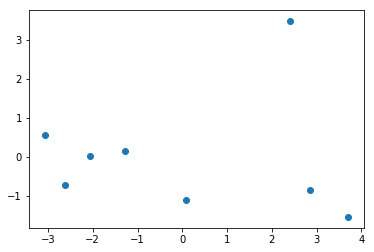

In [433]:
plt.scatter(zzs[:,0],zzs[:,1])

In [396]:
Z[0][0]

tensor([-0.3276,  0.6415,  0.7887, -0.6501, -1.2003,  0.9166, -0.7076,  0.5039,
         1.2432,  0.6096, -0.3409, -0.6587,  0.7840, -0.6232,  0.0900, -1.0190,
        -0.9552,  0.7056,  1.2175,  0.7023,  0.9768, -0.3149, -0.9037, -0.7346,
        -1.0264,  0.4083,  0.0118,  0.2533, -0.0292,  1.6221,  0.7579, -1.0551,
        -0.0699,  0.7476,  0.6176, -0.9755,  0.8389, -0.6712,  0.7161, -1.2176,
        -0.4666, -0.8934,  1.3413,  1.1390, -0.7584, -0.6685,  0.8666,  0.4468,
        -0.7967, -1.0268,  0.5058, -0.4739, -0.8744,  0.6780, -0.1814, -0.6863,
        -0.2246,  0.5123, -1.0808,  0.4923,  0.3810, -0.8239, -1.0168,  0.1853,
        -0.8145,  1.0597,  0.9328, -0.0057, -0.4103, -0.4818,  0.9856,  0.8092,
         0.6051, -0.2174,  0.5755,  1.0315,  0.3297, -0.2616, -1.1351,  0.7075,
        -1.0677, -0.7132, -0.4080,  0.7500, -0.4489,  0.5701,  1.2504,  1.1017,
        -0.6701, -0.6380,  0.6964,  0.9191, -1.3468,  1.0550, -1.1498, -0.2130,
         1.0076,  0.8469, -1.1133, -1.40

In [397]:
print(G(Z[0].view(-1,100,1,1)).shape)

torch.Size([32, 1, 28, 28])


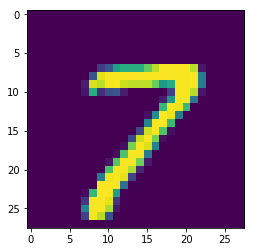

In [434]:
plt.imshow(X[11][0].data.cpu().numpy())

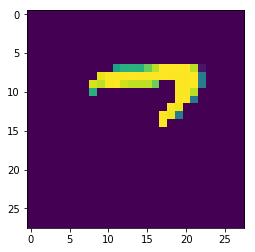

In [436]:
plt.imshow((X*seg).squeeze()[11].data.cpu().numpy())

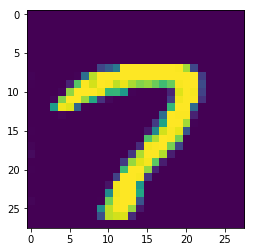

In [447]:
plt.imshow((G(Z[0].view(-1,100,1,1))).squeeze()[11].data.cpu().numpy())

In [410]:
total = []
for i in range(32):
    zs = np.concatenate([
        Z[j][i].data.cpu().numpy().reshape(1,-1) for j in range(4)
    ], axis=0)
    ds = np.triu(dist.squareform(dist.pdist(zs)))
    ds = ds[ds>0]
    total.append(ds)
total = np.array(total).reshape(-1)

(array([ 6.,  2.,  7., 11.,  6.,  4., 10., 58., 64., 24.]),
 array([ 1.27193356,  2.4176086 ,  3.56328365,  4.70895869,  5.85463373,
         7.00030878,  8.14598382,  9.29165886, 10.43733391, 11.58300895,
        12.728684  ]),
 <a list of 10 Patch objects>)

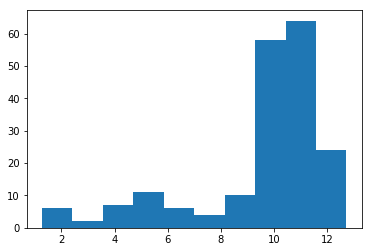

In [411]:
plt.hist(total)

In [162]:
Z[0][1]

tensor([ 2.9919e-01, -8.1644e-02,  2.6438e-01,  3.0647e-01, -7.0847e-01,
         3.5760e-01,  1.6790e-01, -4.6617e-01,  1.2133e-01, -2.3742e-01,
         7.2725e-01, -4.6493e-01, -8.4111e-02, -3.4595e-02, -1.3313e-01,
        -6.5231e-01, -1.4461e-01,  9.1047e-01,  5.0330e-01,  4.2016e-01,
         2.8114e-02,  4.3725e-04, -3.2863e-01, -1.0259e-01,  4.6818e-01,
        -3.5153e-01, -1.0996e-01, -2.8729e-01, -5.5561e-01,  1.1337e+00,
        -8.4365e-02, -5.7040e-01, -2.9011e-02, -4.2616e-01,  2.8891e-01,
        -3.1740e-01,  2.1276e-01,  1.5101e-01, -1.8805e-01, -4.3570e-01,
         8.5150e-02, -4.5952e-02,  9.3705e-01, -2.3732e-01,  2.3384e-01,
        -1.2934e-01, -3.3730e-01,  3.6404e-03, -5.9589e-02,  4.2448e-01,
         1.8267e-01, -8.9470e-02, -8.3780e-02, -5.0989e-01,  1.0338e-01,
         3.0635e-01, -3.1241e-01, -3.6068e-01, -2.3677e-01, -4.5186e-01,
         3.1241e-01,  1.5267e-01, -1.4417e-01, -5.1806e-01,  3.6937e-01,
        -2.5256e-01,  2.5981e-01,  2.4081e-01,  7.4

In [84]:
G(Z[1:2].view(-1,100,1,1)).shape

torch.Size([1, 1, 28, 28])

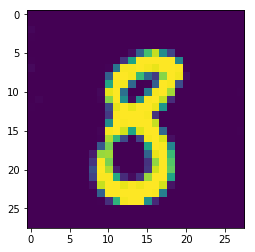

In [109]:
plt.imshow(G(Z[10:11].view(-1,100,1,1)).squeeze().data.cpu().numpy())

## How do the Mu, Sigmas look like?

In [150]:
m = mu.data.cpu().numpy()
s = sigma.data.cpu().numpy()

In [151]:
m[0]

array([ 1.0141715e+00,  1.3437636e+00, -1.3984764e+00,  1.8980034e-01,
       -1.0001565e+00,  2.2201841e+00,  1.0336254e+00, -2.1270679e-01,
        8.7877519e-02, -7.7630746e-01,  1.6453948e+00, -3.4353977e-01,
       -2.3263927e+00, -6.5208949e-02, -6.4731044e-01, -1.6811272e+00,
       -3.2108474e+00, -1.9325836e+00,  2.9254854e-01,  2.6697338e+00,
        2.6524442e-01,  1.3056307e+00, -7.5931209e-01,  4.0532750e-01,
        3.1629336e+00, -5.3920794e-01, -7.1749151e-01, -3.8251710e-01,
       -2.9130113e+00,  1.5351162e+00, -1.5903302e+00,  1.3519646e+00,
       -2.3706147e-01, -2.8276372e-01, -3.9815218e+00, -8.2983899e-01,
       -1.3153306e+00,  6.7988580e-01,  7.1268713e-01,  6.4165443e-01,
        1.9195082e+00,  4.4204774e+00, -1.2608528e+00,  9.8567826e-01,
       -6.9368201e-01, -6.3427314e-02, -1.5886703e+00, -5.8516210e-01,
       -8.3985287e-01,  2.5735049e+00,  4.5413932e-01, -1.9334494e-01,
       -2.8392062e-01, -7.9367030e-01,  3.4559269e-02, -1.4370286e+00,
      

In [153]:
s[0]

array([0.50005543, 0.5000511 , 0.50031155, 0.5001092 , 0.5001127 ,
       0.5000804 , 0.5000885 , 0.5001263 , 0.5000511 , 0.50007045,
       0.5001442 , 0.5000895 , 0.5001329 , 0.5001166 , 0.5001045 ,
       0.50007683, 0.5001015 , 0.50010484, 0.500033  , 0.50008035,
       0.5001264 , 0.5000566 , 0.5000837 , 0.5000803 , 0.5000774 ,
       0.5001519 , 0.5002141 , 0.500118  , 0.50005996, 0.5001833 ,
       0.50029093, 0.50030893, 0.50016147, 0.5001057 , 0.5000972 ,
       0.50037044, 0.50005955, 0.5001552 , 0.5002968 , 0.50023645,
       0.5001222 , 0.500121  , 0.5000537 , 0.50007826, 0.5000625 ,
       0.500264  , 0.5001122 , 0.50011545, 0.50006086, 0.5000936 ,
       0.50010645, 0.500112  , 0.50009763, 0.5001165 , 0.5000827 ,
       0.5001549 , 0.5000615 , 0.5000416 , 0.5000763 , 0.50010765,
       0.5002593 , 0.5001957 , 0.5003021 , 0.5001714 , 0.5001316 ,
       0.5002391 , 0.50003886, 0.50005573, 0.5000618 , 0.50018054,
       0.5001373 , 0.500248  , 0.50019854, 0.5004428 , 0.50014

In [157]:
sampled = (mu[0] + 1*torch.randn(size=(32,100)).cuda())

In [158]:
hmm = G(sampled.reshape(-1,100,1,1))

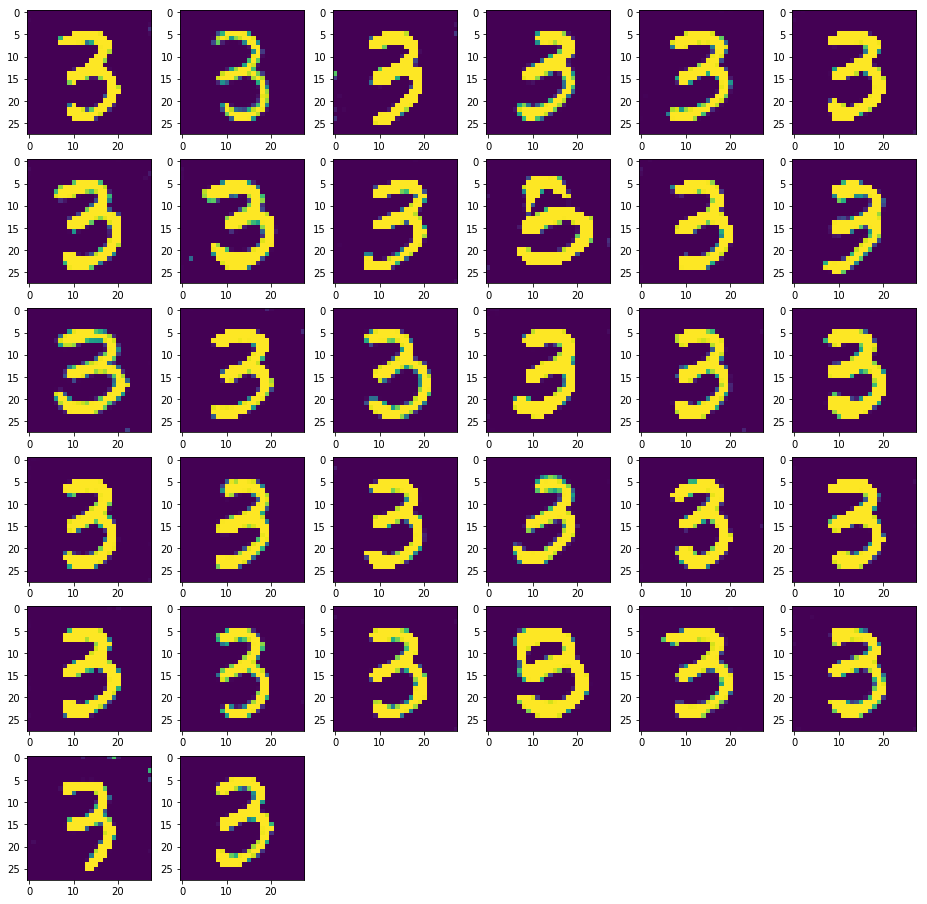

In [159]:
fig = plt.figure(figsize=(16,16))
for i in range(32):
    ax = plt.subplot(6,6,i+1)
    ax.imshow(hmm.squeeze()[i].data.cpu().numpy())

## Now Let's View Zs

In [160]:
z = sampled.data.cpu().numpy()

In [161]:
dists = dist.squareform(dist.pdist(z))
triu = np.triu(dists)

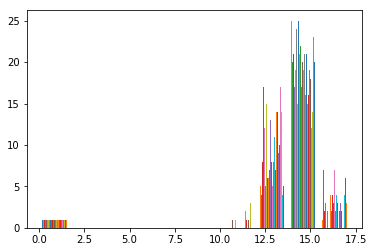

In [162]:
plt.hist(dists,bins=10);

## Testing With Anchors

found max_dist of  3.866666666666666  created  15  segments


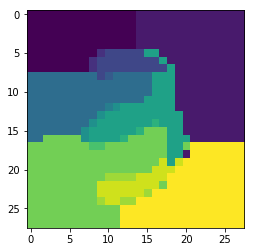

In [191]:
image = X[0].squeeze().data.cpu().numpy()
segments = image_utils.create_segments(image, kernel_size=2, max_dist=3, ratio=0.2)
plt.imshow(segments)

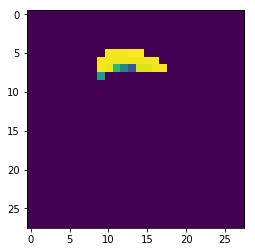

In [263]:
exp_ = {}
exp_['feature'] = [3]
_,mask = image_utils.create_mask(image,segments,exp_)
target = mask*((image-0.5)*2)
plt.imshow(target)

In [222]:
importlib.reload(csgm)

<module 'csgm' from '/home/kurtis/Desktop/anchor/ImageAnchors/csgm.py'>

In [223]:
mu[0].shape

torch.Size([100])

In [268]:
x_csgm,reconstruct,_ = csgm.reconstruct_batch(target, mask, np.sum(mask), G, 100, threshold=0.05)

0.06255523


In [269]:
dists = dist.squareform(dist.pdist(x_csgm.squeeze()))
triu = np.triu(dists)

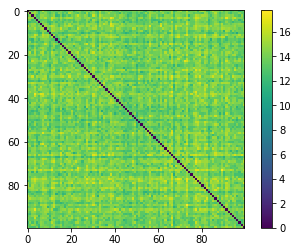

In [270]:
plt.imshow(dists)
plt.colorbar()

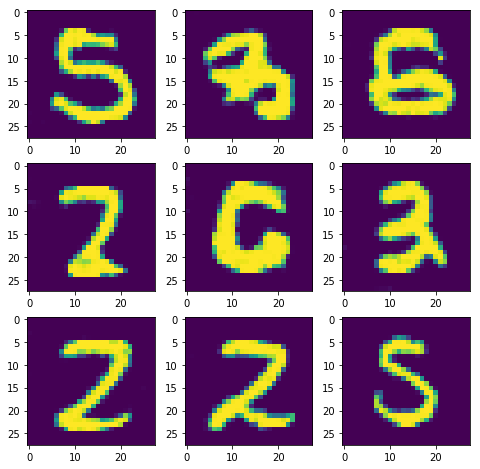

In [271]:
fig = plt.figure(figsize=(8,8))
for i in range(9):
    ax = plt.subplot(3,3,i+1)
    ax.imshow(reconstruct[i])